This notebook is built off of Germano's existing LSCP notebook:

Attempt to solve Location Coverage Backup Problem as a script and access PuLP manually (outside of PySAL spopt ecosystem)

In [407]:
from spopt.locate.coverage import LSCP
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
from pulp import *
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [408]:
CLIENT_COUNT = 10 # quantity demand points
FACILITY_COUNT = 3 # quantity supply points

MAX_COVERAGE = 8 # maximum service radius in meters

# Random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

In [409]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

In [410]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

<AxesSubplot:>

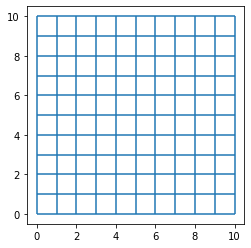

In [411]:
street.plot()

In [412]:
client_points = simulated_geo_points(street_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

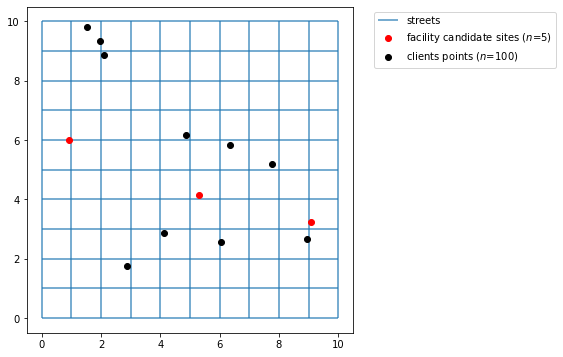

In [413]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
client_points.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [414]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

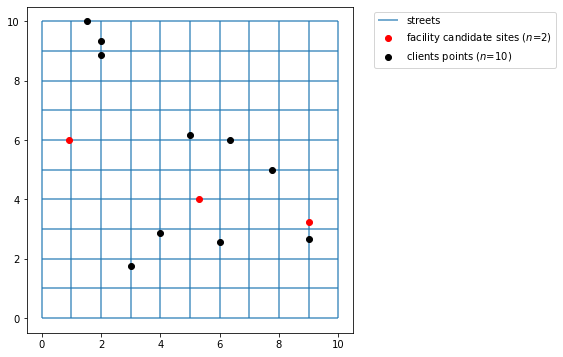

In [415]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=2)')
clients_snapped.plot(ax=ax, color='black', label='clients points ($n$=10)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [416]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

In [417]:
cost_matrix

array([[12.60302601,  3.93598651,  8.16571655],
       [13.10096347,  4.43392397,  8.66365401],
       [ 6.9095462 ,  4.2425067 ,  2.47223674],
       [ 2.98196832,  7.84581224,  3.45534114],
       [ 7.5002892 ,  6.32806975,  4.55779979],
       [ 0.60209077, 11.42987132,  5.03940023],
       [ 5.37335867,  6.20113923,  2.43086927],
       [ 5.40801577,  5.41976478,  3.02929369],
       [ 3.68807115,  8.51585171,  2.12538061],
       [14.22503627,  4.60274429,  9.78772681]])

In [418]:
# create an array, mark values with a 1 if <= 8
# all other values marked w/ zero (no coverage)
aij = numpy.zeros(cost_matrix.shape)
aij[cost_matrix <= 8] = 1
#! aij is the coverage matrix
aij

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 0., 1.],
       [0., 1., 0.]])

All code before this is really just setup... Now with the information we have how can we use the PuLP solver to solve for maximizing backup coverage?

In [493]:
# create a LP problem with the method LpProblem in PuLP
del(prob)
prob = LpProblem("LSCP-B", LpMaximize)

In [494]:
range_client = range(cost_matrix.shape[0]) #how many clients?
range_facility = range(cost_matrix.shape[1]) #how many facilities?

In [495]:
# create variables for the facilities, demand nodes, and coverage
fac_vars = [
    LpVariable(
        "facility_{}".format(i), lowBound=0, upBound=1, cat=LpInteger
    )
    for i in range_facility
]
print(fac_vars)

#may not need to be a variable....
dem_vars = [
    LpVariable(
        "demandNode_{}".format(i), lowBound=0, upBound=1, cat=LpInteger
    )
    for i in range_client
]
print(dem_vars)

# coverage variable - this variable should be 1 anytime a demand node is covered > 1x
# i feel like this varibale should be created differently so that it is either assigned 0,1
# based on the coverage status of a demand node
cov_var = [
    LpVariable(
        "coverage_{}".format(i), lowBound=0, upBound=1, cat=LpInteger
    )
    for i in range_client
]
    
print(cov_var)

[facility_0, facility_1, facility_2]
[demandNode_0, demandNode_1, demandNode_2, demandNode_3, demandNode_4, demandNode_5, demandNode_6, demandNode_7, demandNode_8, demandNode_9]
[coverage_0, coverage_1, coverage_2, coverage_3, coverage_4, coverage_5, coverage_6, coverage_7, coverage_8, coverage_9]


In [496]:
#from spopt  lpSum([ni[i][j] * fac_vars[j] for j in range_facility]) >= 1

# this is still quite useful - it describes the relationship between facilities & demand nodes
'''for i in range_client:
    prob += (
        # I should understand the below line better // maybe have them reiterate for me?
        #!lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + cov_var[i]
        lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + cov_var[i]
    )'''

for i in range_client:
    if sum(aij[i]) >=2: # demand unit has multiple coverage
        prob += (
            lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + 1*cov_var[i]
        )
    else: #demand unit only has single coverage
        prob += (
            lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + 0*cov_var[i]
        )

#!prob += lpSum(1*i for i in fac_vars), "objective function"
prob += lpSum(1*i for i in cov_var), "objective function"

#!demand nodes should be <= 1
#for i in range_client: # 10 clients
#    prob += lpSum( [ dem_vars[i] for k in dem_vars ] ) <= 1

#constraints:
#  - the number of facilities chosen should be <= P
#  - all facilities should be either 0 or 1
#  - Ui should be <= 1 

p = 2 # max number of facilities
#prob += lpSum(fac_vars) == p, "Facility Constraint"
prob += LpConstraint(sum(fac_vars), sense=LpConstraintE, rhs=2, name='Facility Constraint')

print(prob)

LSCP-B:
MAXIMIZE
1*coverage_0 + 1*coverage_1 + 1*coverage_2 + 1*coverage_3 + 1*coverage_4 + 1*coverage_5 + 1*coverage_6 + 1*coverage_7 + 1*coverage_8 + 1*coverage_9 + 0
SUBJECT TO
_C1: facility_1 >= 1

_C2: facility_1 >= 1

_C3: - coverage_2 + facility_0 + facility_1 + facility_2 >= 1

_C4: - coverage_3 + facility_0 + facility_1 + facility_2 >= 1

_C5: - coverage_4 + facility_0 + facility_1 + facility_2 >= 1

_C6: - coverage_5 + facility_0 + facility_2 >= 1

_C7: - coverage_6 + facility_0 + facility_1 + facility_2 >= 1

_C8: - coverage_7 + facility_0 + facility_1 + facility_2 >= 1

_C9: - coverage_8 + facility_0 + facility_2 >= 1

_C10: facility_1 >= 1

Facility_Constraint: facility_0 + facility_1 + facility_2 <= 2

VARIABLES
0 <= coverage_0 <= 1 Integer
0 <= coverage_1 <= 1 Integer
0 <= coverage_2 <= 1 Integer
0 <= coverage_3 <= 1 Integer
0 <= coverage_4 <= 1 Integer
0 <= coverage_5 <= 1 Integer
0 <= coverage_6 <= 1 Integer
0 <= coverage_7 <= 1 Integer
0 <= coverage_8 <= 1 Integer
0 <

In [497]:
prob.solve()

print('Coverage Values')   
for i in cov_var:
    print(i.varValue)

print('\n'+'Total Coverage Values:', value(prob.objective))

#facility_2 is marked as zero - not needed, which I believe is the solution?
print('\n'+ 'Facility Values')
for i in fac_vars:
    print(i.varValue)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/pysaldev/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/fq/47y89n756hg5n9zwbqd79nhw0000gn/T/b16385985b0f4ad4bcd1d1bedb81d605-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/fq/47y89n756hg5n9zwbqd79nhw0000gn/T/b16385985b0f4ad4bcd1d1bedb81d605-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16 COLUMNS
At line 85 RHS
At line 97 BOUNDS
At line 111 ENDATA
Problem MODEL has 11 rows, 13 columns and 32 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -8 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 

In [114]:
lscp_from_cost_matrix = LSCP.from_cost_matrix(cost_matrix, MAX_COVERAGE)

In [115]:
lscp_from_cost_matrix.problem

LSCP:
MINIMIZE
1*x_0_ + 1*x_1_ + 0
SUBJECT TO
_C1: x_1_ >= 1

_C2: x_1_ >= 1

_C3: x_0_ + x_1_ >= 1

_C4: x_0_ + x_1_ >= 1

_C5: x_0_ + x_1_ >= 1

_C6: x_0_ >= 1

_C7: x_0_ + x_1_ >= 1

_C8: x_0_ + x_1_ >= 1

_C9: x_0_ >= 1

_C10: x_1_ >= 1

VARIABLES
0 <= x_0_ <= 1 Integer
0 <= x_1_ <= 1 Integer